In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import seaborn as sns
import timm
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv(r'/kaggle/input/digit-recognizer/train.csv', dtype = np.float32)
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
targets_numpy = df.label.values
features_numpy = df.loc[ : , df.columns != 'label'].values/255
display(targets_numpy, features_numpy)

array([1., 0., 1., ..., 7., 6., 9.], dtype=float32)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy, targets_numpy, test_size=0.2, random_state=42)

In [7]:
# transform to tensors
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

In [8]:
train_dataset = TensorDataset(featuresTrain, targetsTrain)
test_dataset = TensorDataset(featuresTest, targetsTest)

In [10]:
batch_size = 100
num_iterations = 6000
num_epochs = num_iterations / (len(featuresTrain) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

17


In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle =False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

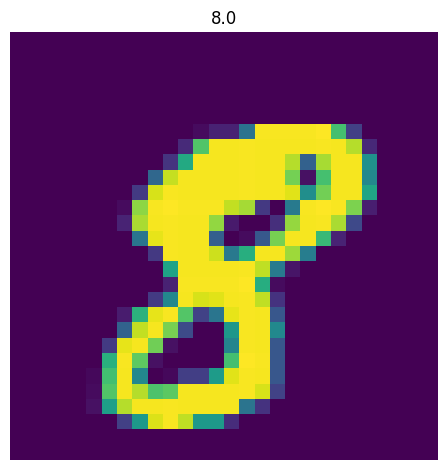

In [24]:
plt.imshow(features_numpy[10].reshape(28,28)) #first mistake resize vs reshape
plt.axis('off')
plt.title(str(targets_numpy[10]))
plt.savefig('image.png')
plt.tight_layout()
plt.show()

In [28]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self,x):
        #hidden state
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        #cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        out, (hn,cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        out = self.fc(out[:,-1,:])
        
        return out

input_dim = 28
layer_dim = 1
hidden_dim = 100
output_dim = 10
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [29]:
seq_dim = 28
loss_list, iteration_list, accuracy_list = [], [], []
count = 0

for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_dataloader):
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        count += 1
        if count%500==0:
            total = 0
            correct = 0
            for images,labels in test_dataloader:
                images = images.view(-1,seq_dim,input_dim)
                outputs = model(images)
                _, predicted = torch.max(outputs,1)
                total += labels.size(0)
                correct += (predicted==labels).sum()
            accuracy = 100*correct / total
            
            loss_list.append(loss.data.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)
print('Iterations: {}, Losses: {}, Accuracy_Score: {}'.format(count, loss.data.item(), accuracy))

Iterations: 5712, Losses: 0.019803624600172043, Accuracy_Score: 97.08333587646484
